# Decision trees

This chapter is based on Raschka, chapter 3, and Geron, chapters 6 and 7.

Decision trees are among the most important machine learning methods. Individual decision trees offer the advantage of being easily interpreted. Random Forests are combinations of decision trees that are among the most powerful ML methods.

## An illustration of a simple decision tree

<center>
<img src="images/03_17.png" align="center" width="900" />
</center>
(Raschka, ch 3)

## Building a decision tree

Decision trees are implemented in scikit-learn in the classes `DecisionTreeClassifier` and `DecisionTreeRegressor`. We will consider the classifier first. We will display decision trees using `plot_tree`.

In [1]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.datasets import load_iris
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.datasets import make_moons

%matplotlib inline

As in the previous chapter, we will use the Iris data set.

In [2]:
iris = load_iris()
X = iris.data[:, [2, 3]]
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)

Decision trees do not benefit from standardizing the features. We thus use the original data to create a `DecisionTreeClassifier` object and apply the `fit` method. There are various hyperparameters we could set, though we use the default values for most of them.

We set the maximum depth of the tree to 2 and pass a seed for the random number generator to make the tree replicable. Limiting `max_depth` is one way to avoid overfitting of the training data, which could lead to worse performance on the test data. Other hyperparameters can serve a similar purpose.

In [3]:
tree_clf = DecisionTreeClassifier(max_depth=2, random_state=1)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2, random_state=1)

The function `plot_tree` displays the decisions taken at each level of the tree and returns a description of the tree.

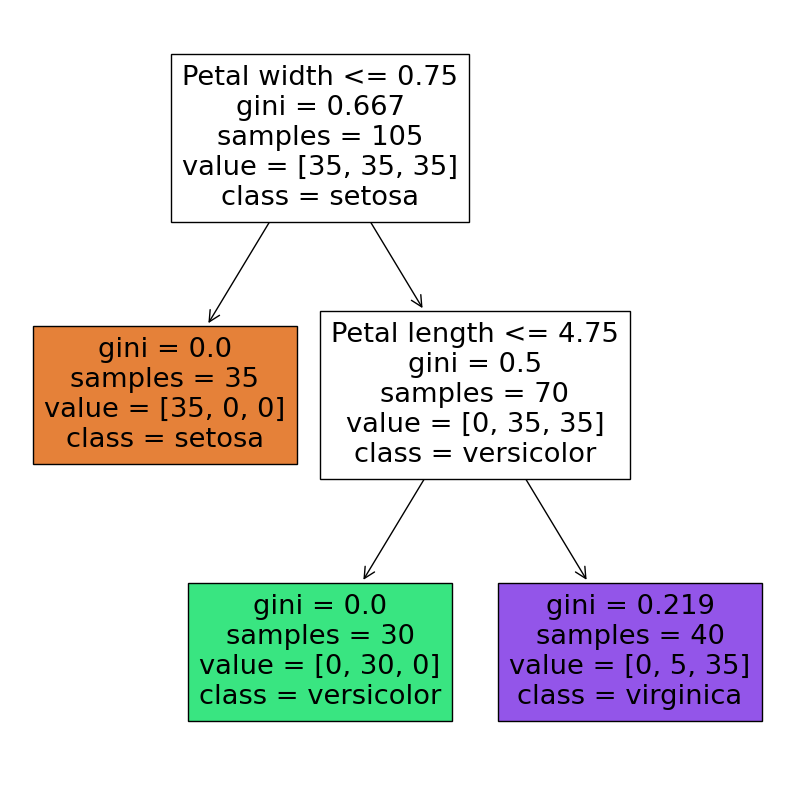

In [4]:
fig, ax = plt.subplots(figsize=(10, 10))

plot_tree(tree_clf, filled = True, feature_names=["Petal length", "Petal width"], 
          class_names=['setosa', 'versicolor', 'virginica'], ax=ax)
plt.show()

At the root of the tree, the data is split into those samples for which the feature "Petal width" is greater and smaller or equal to 0.75, respectively.

`gini` measures the __impurity__ of the data in this node, i.e., if `gini` = 0, a node contains samples of only one category (more on this later). `samples` is the number of samples contained in the branch of the node, and the list `value` gives the number of samples of each category that are contained in the branch.

Since there is no impurity in the left branch, there is no need to split the data further. On the right branch, the remaining samples are split according to their values of the feature "Petal length". One of the nodes at level 2 still has some impurity, but there is no further branching because we set the depth of the tree to 2.

The decisions taken by the tree classifier can be displayed in decision regions in the same way as previously seen in the case of the Perceptron.

In [5]:
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl)

    # highlight test samples
    if test_idx:
        # plot all samples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='none',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='test set')

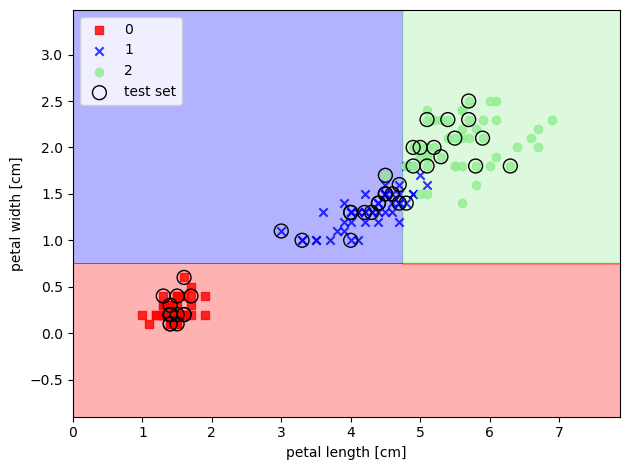

In [6]:
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X_combined, y_combined, 
                      classifier=tree_clf, test_idx=range(105, 150))

plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

We can predict the class using the `predict` method, and estimate the probabilities of all classes using the method `predict_proba`.

In [7]:
tree_clf.predict([[5, 1.5]])

array([2])

In [8]:
tree_clf.predict_proba([[5, 1.5]])

array([[0.   , 0.125, 0.875]])

## The CART algorithm

scikit-learn uses the __Classification and Regression Tree (CART)__ algorithm, which creates binary trees. There also exist other algorithms that allow a node to have more than two children.

Starting with the root node, the algorithm chooses in each node the feature $m$ and threshold $t_m$ that minimize the cost function $J$, which is a function of the __impurity__ of the child nodes, weighted by those nodes' sizes, i.e., numbers of samples.

For a measure of impurity $I$, the cost function to be minimized is

\begin{align}
J(m,t_m) = \frac{n_{\text{left}}}{n}I_{\text{left}} + \frac{n_{\text{right}}}{n}I_{\text{right}}
\end{align}

where $n$ is the total number of samples in the node, $n_{\text{left/right}}$ is the number of samples in the left and right child node, respectively, and $I_{\text{left/right}}$ is the impurity measure of the samples contained in the left and right child node, respectively.

The CART algorithm is an example of a __greedy algorithm__: it takes a decision for the split in a node without regard for the performance within its left and right branches. Thus, it is not guaranteed to find the best possible solution.

## Measures of impurity

scikit-learn offers the choice between two measures of impurity: `gini` (the default) and `entropy`. Gini impurity for a node $d$ and a classication problem with $c$ classes is defined as
\begin{align}
I_G(d) = 1 - \sum_{i=1}^c p(i|d)^2
\end{align}
where $p(i|d)$ is the proportion of samples in node $d$ that belongi to class $i$.

Entropy is defined as
\begin{align}
I_E(d) = - \sum_{i=1, p(i|d)\neq 0}^c p(i|d) log_2 p(i|d)
\end{align}
The two measures are, as shown below, quite similar. Entropy tends to create more balanced trees, whereas Gini often creates one branch containing only the samples with the most frequent class.

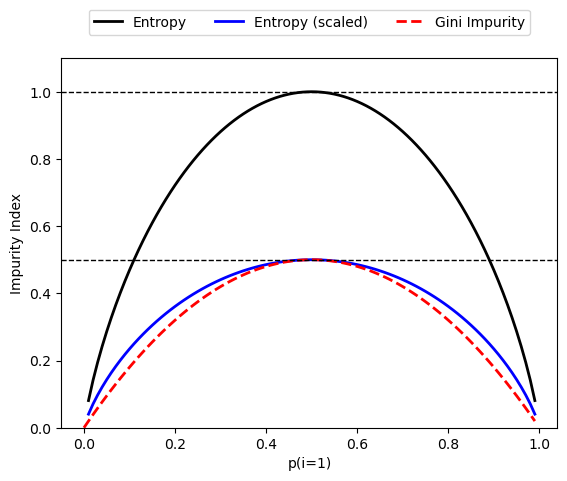

In [9]:
def gini(p):
    return 1-(p**2 + (1 - p)**2)

def entropy(p):
    return - p * np.log2(p) - (1 - p) * np.log2((1 - p))

x = np.arange(0.0, 1.0, 0.01)

ent = [entropy(p) if p != 0 else None for p in x]
sc_ent = [e * 0.5 if e else None for e in ent]

fig = plt.figure()
ax = plt.subplot(111)
for i, lab, ls, c, in zip([ent, sc_ent, gini(x)], 
                          ['Entropy', 'Entropy (scaled)', 
                           'Gini Impurity'],
                          ['-', '-', '--'],
                          ['black', 'blue', 'red', 'green']):
    line = ax.plot(x, i, label=lab, linestyle=ls, lw=2, color=c)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
          ncol=5, fancybox=True, shadow=False)

ax.axhline(y=0.5, linewidth=1, color='k', linestyle='--')
ax.axhline(y=1.0, linewidth=1, color='k', linestyle='--')
plt.ylim([0, 1.1])
plt.xlabel('p(i=1)')
plt.ylabel('Impurity Index')
plt.show()

# Regression trees

Decision trees can also be used on regression tasks. To illustrate the usage of the `DecisionTreeRegressor`, we create some data that we then fit.

We are not splitting the data into training and test data sets here. In a practical application of the method, we would do so.

In [10]:
np.random.seed(42)
n = 200
X = np.random.rand(n, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(n, 1) / 10

In [11]:
tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

When displaying the tree, each node is associated with one value instead of the list of frequencies we had seen in the classification task. The values are the predicted values.

The cost function for a regression is the __Mean Squared Error (MSE)__. With $m$ a feature and $t_m$ a threshold, it is defined as

\begin{align}
J(m,t_m) = \frac{n_{\text{left}}}{n}MSE_{\text{left}} + \frac{n_{\text{right}}}{n}MSE_{\text{right}}
\end{align}
where
\begin{align}
MSE_{\text{node}} = \frac{1}{N_{\text{node}}}\sum_{n\in \text{node}}\Big(\hat{y}_{\text{node}}-y^{(n)}\Big)^2
\end{align}
and
\begin{align}
\hat{y}_{\text{node}} = \frac{1}{N_{\text{node}}}\sum_{n\in \text{node}}y^{(n)}
\end{align}

The MSE displayed in each node corresponds to the MSE that we would obtain if we only considered the samples and predicted values for the samples associated with this node.

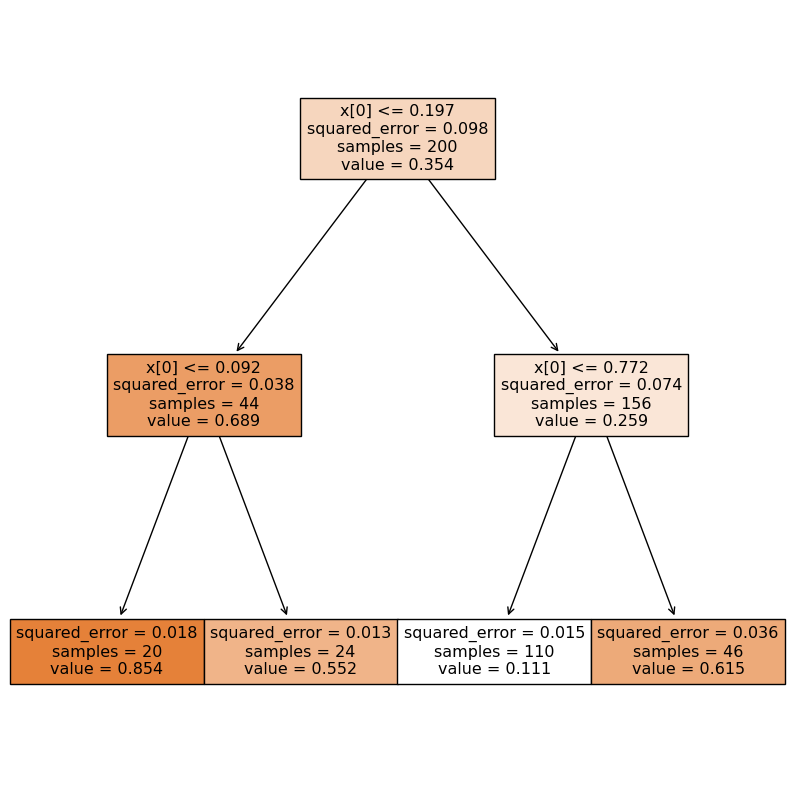

In [12]:
fig, ax = plt.subplots(figsize=(10, 10))

plot_tree(tree_reg, filled = True, ax=ax)
plt.show()

We also train a `DecisionTreeRegressor` with `max_depth=3` and illustrate the regressors graphically.

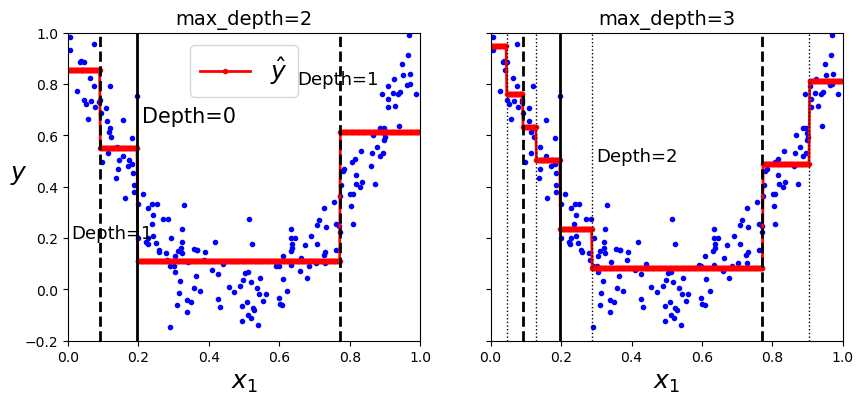

In [13]:
tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=2)
tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=3)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_regression_predictions(tree_reg1, X, y)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
plt.text(0.21, 0.65, "Depth=0", fontsize=15)
plt.text(0.01, 0.2, "Depth=1", fontsize=13)
plt.text(0.65, 0.8, "Depth=1", fontsize=13)
plt.legend(loc="upper center", fontsize=18)
plt.title("max_depth=2", fontsize=14)

plt.sca(axes[1])
plot_regression_predictions(tree_reg2, X, y, ylabel=None)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
for split in (0.0458, 0.1298, 0.2873, 0.9040):
    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)
plt.text(0.3, 0.5, "Depth=2", fontsize=13)
plt.title("max_depth=3", fontsize=14)

plt.show()

If we remove the restriction on the depth of the tree, we can see that it is overfitting the data. An alternative to limiting the depth is to use `min_samples_leaf` to require a minimum number of samples in each leaf.

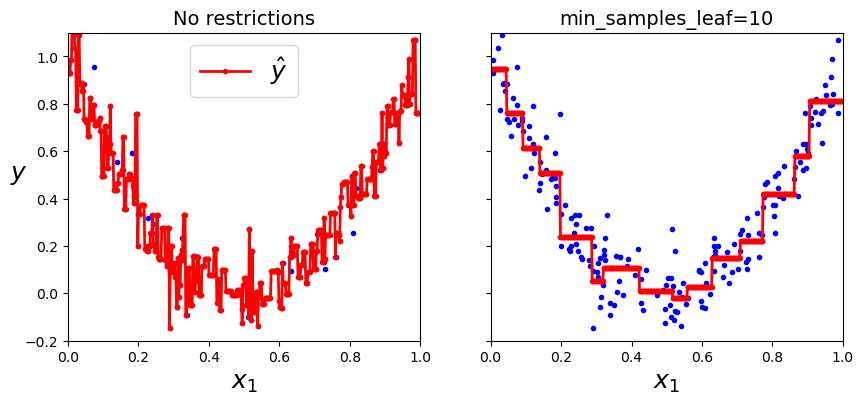

In [14]:
tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

x1 = np.linspace(0, 1, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plt.plot(X, y, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", fontsize=18, rotation=0)
plt.legend(loc="upper center", fontsize=18)
plt.title("No restrictions", fontsize=14)

plt.sca(axes[1])
plt.plot(X, y, "b.")
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.title("min_samples_leaf={}".format(tree_reg2.min_samples_leaf), fontsize=14)

plt.show()

## Instability

It is generally the case that small changes to a data set can lead to substantially different looking decision trees, though this doesn't necessarily mean they perform differently well.

Probably more importantly, since each node in a decision tree considers only one feature, it is an advantage to have orthogonal decision boundaries. The following example illustrates this. It represents two estimations based on identical data, except that the data in the second case has been rotated.

This issue illustrates that it can be important to create features that individually explain much of the variation in the data.

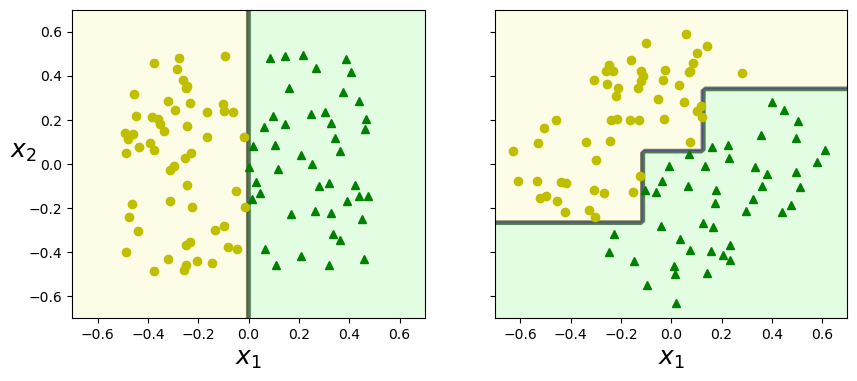

In [15]:
def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
    plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^")
        plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)


np.random.seed(6)
Xs = np.random.rand(100, 2) - 0.5
ys = (Xs[:, 0] > 0).astype(np.float32) * 2

angle = np.pi / 4
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xsr = Xs.dot(rotation_matrix)

tree_clf_s = DecisionTreeClassifier(random_state=42)
tree_clf_s.fit(Xs, ys)
tree_clf_sr = DecisionTreeClassifier(random_state=42)
tree_clf_sr.fit(Xsr, ys)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf_s, Xs, ys, axes=[-0.7, 0.7, -0.7, 0.7])
plt.sca(axes[1])
plot_decision_boundary(tree_clf_sr, Xsr, ys, axes=[-0.7, 0.7, -0.7, 0.7])
plt.ylabel("")

plt.show()

# Random Forests

Random Forests are an __ensemble learning__ algorithm. Ensemble methods combine multiple learners to create one superior, more robust learner. A random forest is an ensemble of decision trees.

`sklearn` provides the classes `RandomForestClassifier` and `RandomForestRegressor`. Therefore, it is not necessary to explicitly code the process of combining multiple trees.

The random forest algorithm trains `n_estimators` decision trees (default `n_estimators=100`). These decision trees don't use the original data set but __bootstrap__ samples that are created by drawing random samples from the training set with replacement. The number of samples drawn is equal to the size of the training set. The argument `max_samples` can be used to change this.

When constructing each decision tree, there is only a random subset of features considered at each node, among which the best is chosen. By default, the number of features drawn is the square root of the number of features in the data. The argument `max_features` can be used to change this.

Finally, in the case of the `RandomForestClassifier`, the predicted class is decided by majority vote among all trees contained in the forest. In the case of the `RandomForestRegressor`, the predicted value is the average of the predictions made by the trees contained in the forest.

We will illustrate a `RandomForestClassifier` using the iris data set.

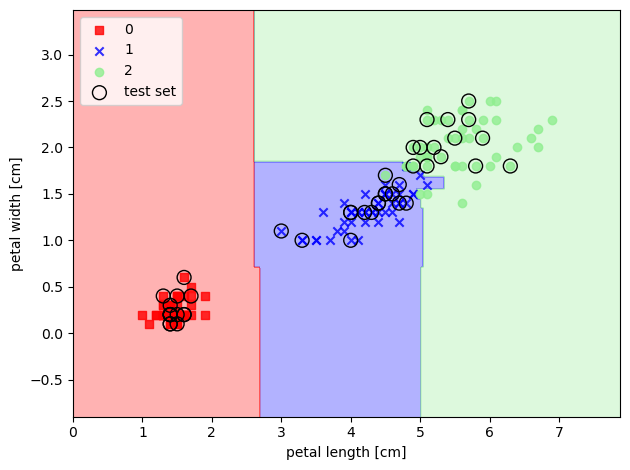

In [16]:
forest = RandomForestClassifier(criterion='gini',
                                n_estimators=25, 
                                random_state=1,
                                n_jobs=2)
forest.fit(X_train, y_train)

plot_decision_regions(X_combined, y_combined, 
                      classifier=forest, test_idx=range(105, 150))

plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

The list `feature_importances` contains the proportion each feature contributes to the reduction in the cost function.

In [17]:
forest.feature_importances_

array([0.52140135, 0.47859865])

To illustrate the `RandomForestRegressor`, we will go back to the regression task we had considered earlier for the `DecisionTreeRegressor`.

In [18]:
np.random.seed(42)
n = 200
X = np.random.rand(n, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(n, 1) / 10

In [19]:
forest = RandomForestRegressor(n_estimators=25, random_state=1, n_jobs=2)
forest.fit(X, y.ravel())

RandomForestRegressor(n_estimators=25, n_jobs=2, random_state=1)

The plot suggests that the regressor substantially overfits the data. To prevent this, we would have to change the hyperparameters, e.g., `max_depth`.

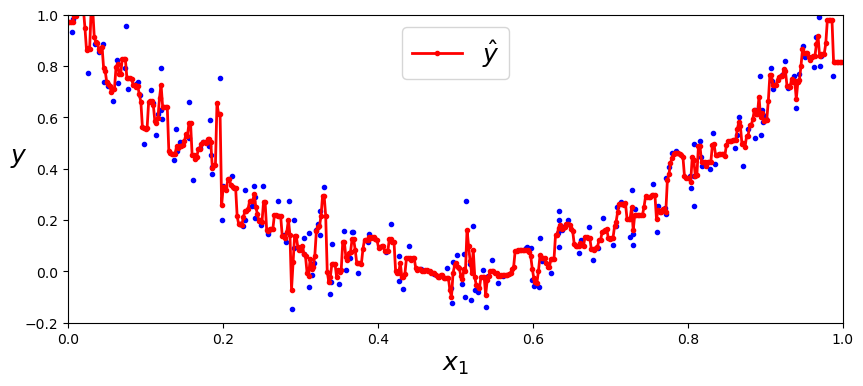

In [20]:
fig, axes = plt.subplots(figsize=(10, 4), sharey=True)
plot_regression_predictions(forest, X, y)
plt.legend(loc="upper center", fontsize=18)
plt.show()

In [21]:
forest = RandomForestRegressor(n_estimators=25, random_state=1, n_jobs=2, max_depth=4)
forest.fit(X, y.ravel())

RandomForestRegressor(max_depth=4, n_estimators=25, n_jobs=2, random_state=1)

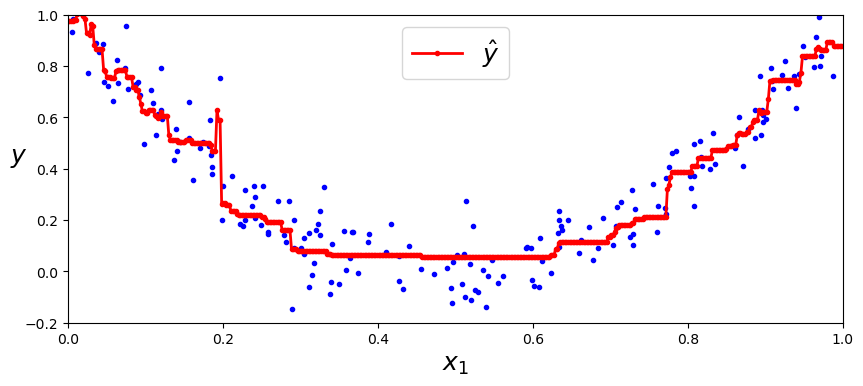

In [22]:
fig, axes = plt.subplots(figsize=(10, 4), sharey=True)
plot_regression_predictions(forest, X, y)
plt.legend(loc="upper center", fontsize=18)
plt.show()